# FGS Commissioning Tool Tutorial

This tutorial will walk you through how to use the various tools within the FGS Commissioning Tools package. These tools comprise of four main components:

> ### 1. NIRCam to FGS Image Conversion (``convert_image``)
This tool can take in a simulated (or real) NIRCam image and will convert it to an FGS (guider 1 or guider 2) image. In addition to rotating the image, adjusting the pixel scale and image size, this tool corrects bad pixels and normalizes the image to a specific magnitude of star.

> ### 2. Star Selection Tool (``star_selector``)
This tool will take the FGS image either created with the first tool, or an FGS image that it is passed by the user, and allow the user to choose the guide star and reference stars using a GUI.

> ### 3. Flight Software File Creation (``fsw_file_writer``)
This module requires an FGS image and a file that includes a list of the coordinates of the guide star and reference stars, along with their count rates. This tool will create all files necessary to test this image different flight software simulators (FGS DHAS, FGSES, etc.) These include all the files necessary to run the ID, ACQ1, ACQ2, and TRK steps in these simulators.

> ### 4. Segment Guiding Tool (``segment_guiding``)
Used to faciliate guiding on unstacked segment arrays during commissioning. When provided 1) the commanded RA and Dec of a guide star and 2) the V2/V3 (or x/y) positions of all segments in an array, the segment guiding tool calculates the effective RA and Dec of all segments on the sky. 

These components can be run together (e.g. input a NIRCam image, output flight software and segment guiding files for user-selected guide and reference stars) or individually (e.g. convert a number of NIRCam image to FGS images; generate a segment guiding file from a list of segment coordinates, etc...).

### Tutorial Table of Contents:
* End-to-End tutorial
     * [Example: CMIMF + FGS](#CMIMFFGS)
     * [Example: GA + NIRCam](#GANIRCam)
* Individual module tutorials:
    * [Image Conversion to FGS](#nircamtofgs)
    * [Selecting Stars](#starselector)
    * [Writing files for flight software](#fswfilewriter)
        * [Rewriting prc and regfiles only](#rewrite)
    * [Using the segment guiding tool](#segmentguiding)
* [How to use the tools in IPython](#ipython)
    
***

# Getting Started

Before we begin, be sure to check that:
* You have installed the **`jwst_fgs_commissioning_tools`** package (as instructed in the readme)
* You are operating in a **Python 3** environment
* You have [**`pysiaf`**](https://grit.stsci.edu/ins-tel/jwst_siaf_prototype) installed
* You have **photutils** installed

In [1]:
import os
from glob import glob

import matplotlib
if matplotlib.get_backend() != 'Qt5Agg':
    matplotlib.use('Qt5Agg')  # Make sure that we are using Qt5
from astropy.io import fits
from astropy.io import ascii as asc
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# Establish paths
current_dir = os.getcwd()
package_dir = os.path.split(current_dir)[0]

In [2]:
from jwst_fgs_commissioning_tools import run_fgs_commissioning_tool

Using backend:  Qt5Agg


<a id='CommTool'></a>
## End-to-end Tutorial: Using `run_fgs_commissioning_tool`

The function that is used to run the tool end-to-end is `run_fgs_commissioning_tool.run_all()`. It will automatically call, in the appropriate succession, `nircam_to_fgs`, `star_selector`, and `fsw_file_writer`. This function takes a number of arguments:

>Required:
* **`input_image`** - filepath for the input (NIRCam or FGS) image 
* **`guider`** - number for guider 1 or guider 2

>Optional:
* **`root`** - if defined, will be used to create the output directory, `./out/{root}`. If not provided, the root name will be derived from the `input_image` filename.
* **`nircam`** - denotes if the `input_image` is an FGS or NIRCam image. If `True`, the image will be converted to FGS format using the `nircam_to_fgs.convert_im` function. The FGS-formatted image will be saved to `./out/{input_image}/FGS_imgs/{input_image}_binned_pad_norm.fits`
* **`global_alignment`** - set to `True` if the provided image is from global alignment, or the PSF-finding algorithm will go haywire.
* **`nircam_det`** - is used to specify the detector of a provided NIRCam image. If left blank, the detector will be extracted from the header of the NIRCam FITS file.
* **`fgs_counts`** and **`jmag`** - used to normalize the input NIRCam image, either to a desired J magnitude or to a desired number of FGS counts. The `jmag` parameter can also be used to normalize an FGS image.
* **`in_file`** - a table of X/Y pixel coordinates and count rates that lists the desired guide star and reference stars; provided in the form of a filepath to a `regfile.txt` or `.incat` file. (Look [here](#in_file) for an example of how to use input files.)
* **`bkgd_stars`** - a developing feature that includes a number of background stars in the final image

Unless otherwise specified, the tool will prompt the user to select guide and reference stars interactively with a GUI. (If you want to bypass the GUI and provide the (x, y) locations and countrates of the guide star and reference star with an incat file or a regfile, provide the appropriate filepath to the `in_file` argument.)
<img src="FGSCommTools_GUI.png">

When the `run_fgs_commissioning_tool.run_all()` function is called, the following files will be created in the `../out/{root}` directory:
* `reg_file.txt` - a list of the pixel coordinates and 3x3 countrate sums of the selected guide and reference stars
* `ALLpsfs.txt` - a list of the pixel coordinates, 3x3 countrate sums, and segment identifier (letter label) of all PSFs found in the image
* `centers.png` - a saved image of the input FGS file, annotated with the locations of all PSFs found in the image
* ID Mode:
 * `sky.fits` (the input file after being time-normalized (converted from counts/s to counts)
 * `bias.fits` (bias file used to create noisy FGS image)
 * `cds.fits` (correlated double sample)
 * `ff.fits` (full frame; image before CDS)
 * `strips.fits` (strips to run in DHAS)
 * `strips.dat` (strips to run in FGSES)
 * `.gssscat`
 * `.stc`
 * `.prc` (to run in DHAS or FGSES)
* ACQ Mode (each for ACQ1 and ACQ2):
 * `sky.fits` (the input file after being time-normalized (converted from counts/s to counts)
 * `bias.fits` (bias file used to create noisy FGS image)
 * `cds.fits` (correlated double sample)
 * `.fits` (to run in DHAS)
 * `.dat` (to run in FGSES)
 * `.cat`
 * `.stc`
 * `.prc` (to run in DHAS or FGSES)
* LOSTRK:
 * `.fits`
 * `.dat` (to run in FGSES)
* TRK:
 * `.fits` (to run in DHAS)
 
Every time that the tool is run, these files will be written - overwriting previous files if given the same `root` directory.

<a id='CMIMFFGS'></a>
### Example: FGS CMIMF Image

In [3]:
input_image_fgs_cmimf = '/user/lchambers/FGS/tool_tutorial/FGS_files/CMIMF.fits'
guider = 1
root_fgs_cmimf = 'tool_tutorial_fgscmimf'

NC = False
nircam_mod = None # default

fgs_counts = None # default
jmag = None # default

GA = False # default

bkgd_stars = False # default

in_file = None # default

**Note:**
When running the GUI in Jupyter Notebooks, sometimes the notebook doesn't wait for user input from the GUI, and as a result, the following function call will fail. If this happens, just call the line again. Do not despair - this never happens when running the tool in IPython! (See [here](#ipython) for brief instructions on how to use the tools in IPython)

In [4]:
# Take care of matplotlib backend business
%matplotlib qt5
plt.close('all')

# Run the tool
run_fgs_commissioning_tool.run_all(input_image_fgs_cmimf, guider, root=root_fgs_cmimf, nircam=NC)

2018-02-27 10:53:46,396 INFO     Started logging to /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/logs/2018_02_27_Tue_105346_run_all_tool_tutorial_fgscmimf.log
2018-02-27 10:53:46,398 INFO     Package directory: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/jwst_fgs_commissioning_tools
2018-02-27 10:53:46,399 INFO     Processing request for tool_tutorial_fgscmimf. 
All data will be saved in: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_fgscmimf
2018-02-27 10:53:46,400 INFO     Input image: /user/lchambers/FGS/tool_tutorial/FGS_files/CMIMF.fits
2018-02-27 10:53:46,401 WARNING  Image Conversion: No counts or J magnitude given, setting to default
2018-02-27 10:53:46,402 INFO     Image Conversion: J magnitude = 11.0, FGS counts = 14779147.9
2018-02-27 10:53:46,403 INFO     Image Conversion: Beginning image conversion to guider 1 FGS image
2018-02-27 10:53:48,505 INFO     Image Conversion: This is an FGS image
2018-02-27 10:53:48,506

### Logging

You might notice that running the tool results in a lot of output - specifically, many lines beginning with a date and time. These lines are also written out to a log file. A new file is generated every time the tool is run, and it can be found in the `../logs` directory.

Now, let's inspect the FGS images that we have just created...

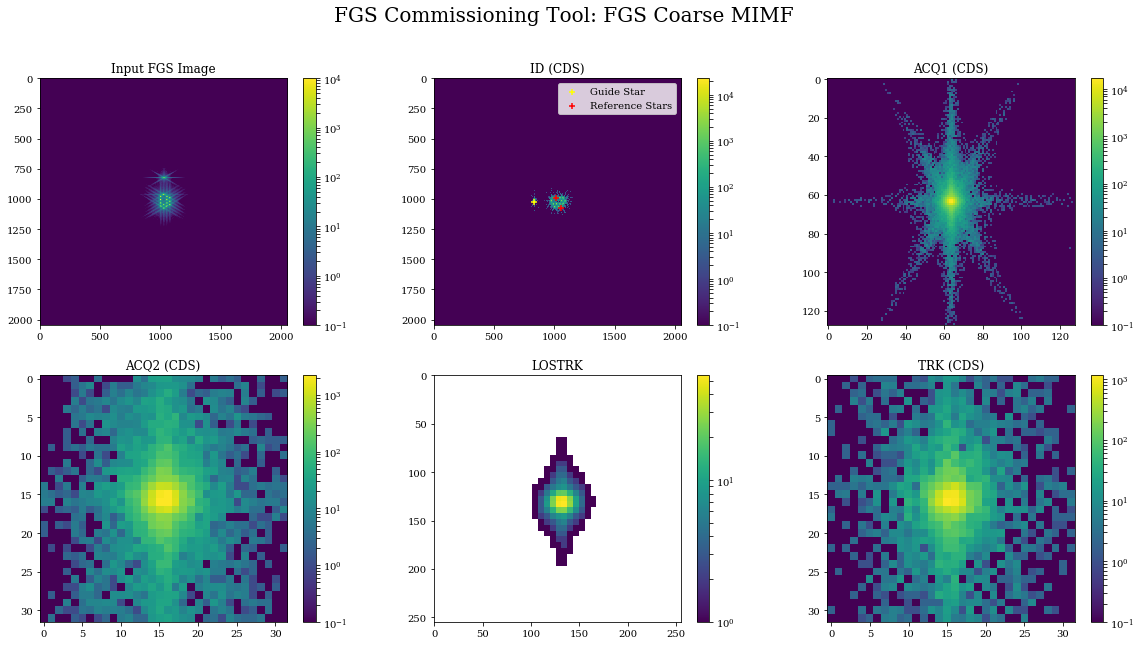

In [5]:
# View the final FGS images
%matplotlib inline
out_dir = os.path.join(package_dir, 'out', root_fgs_cmimf)

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('FGS Commissioning Tool: FGS Coarse MIMF', fontsize=20)

in_data = fits.open(input_image_fgs_cmimf)[1].data
in_data[in_data <= 0] = 0.1
implot = ax1.imshow(in_data, norm=LogNorm(), clim=(1e-1, 1e4))
plt.colorbar(implot, ax=ax1)
ax1.set_title('Input FGS Image')

id_data = fits.open(glob(out_dir + '/stsci/*IDcds.fits')[0])[0].data[0]
id_data[id_data <= 0] = 0.1
implot = ax2.imshow(id_data, norm=LogNorm())
plt.colorbar(implot, ax=ax2)
regfile = glob(out_dir + '/*regfile.txt')[0]
coords = asc.read(regfile)
ax2.scatter(coords['x'][0], coords['y'][0], marker = '+', c= 'yellow', label='Guide Star')
ax2.scatter(coords['x'][1:], coords['y'][1:], marker = '+', c= 'r', label='Reference Stars')
ax2.legend()
ax2.set_title('ID (CDS)')

acq1_data = fits.open(glob(out_dir + '/stsci/*ACQ1cds.fits')[0])[0].data[0]
acq1_data[acq1_data <= 0] = 0.1
implot = ax3.imshow(acq1_data, norm=LogNorm())
plt.colorbar(implot, ax=ax3)
ax3.set_title('ACQ1 (CDS)')

acq2_data = fits.open(glob(out_dir + '/stsci/*ACQ2cds.fits')[0])[0].data[0]
acq2_data[acq2_data <= 0] = 0.1
implot = ax4.imshow(acq2_data, norm=LogNorm())
plt.colorbar(implot, ax=ax4)
ax4.set_title('ACQ2 (CDS)')

lostrk_data = fits.open(glob(out_dir + '/dhas/*LOSTRK.fits')[0])[0].data
implot = ax5.imshow(lostrk_data, norm=LogNorm())
plt.colorbar(implot, ax=ax5)
ax5.set_title('LOSTRK')

trk_data = fits.open(glob(out_dir + '/dhas/*_TRK.fits')[0])[0].data.astype(float)
trk_data_cds = trk_data[1] - trk_data[0]
trk_data_cds[trk_data_cds <= 0] = 0.1
implot = ax6.imshow(trk_data_cds, norm=LogNorm())
plt.colorbar(implot, ax=ax6)
ax6.set_title('TRK (CDS)')

plt.show()

<a id='GANIRCam'></a>
### Example: NIRCam Global Alignment Image

In [6]:
input_image_nc_ga = '/user/lchambers/FGS/tool_tutorial/NIRCam_files/jw00000_044_001_01100_00000_NRCA3_img.fits'
guider = 1
root_nc_ga = 'tool_tutorial_ncga'

NC = True # default
nircam_mod = None # default

fgs_counts = None # default
jmag = None # default

GA = True

bkgd_stars = False # default

in_file = None # default

In [8]:
# Take care of matplotlib backend business
%matplotlib qt5
plt.close('all')

# Run the tool
run_fgs_commissioning_tool.run_all(input_image_nc_ga, guider, root=root_nc_ga, global_alignment=GA, nircam=NC)

2018-02-27 10:55:29,637 INFO     Started logging to /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/logs/2018_02_27_Tue_105529_run_all_tool_tutorial_ncga.log
2018-02-27 10:55:29,639 INFO     Package directory: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/jwst_fgs_commissioning_tools
2018-02-27 10:55:29,640 INFO     Processing request for tool_tutorial_ncga. 
All data will be saved in: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_ncga
2018-02-27 10:55:29,640 INFO     Input image: /user/lchambers/FGS/tool_tutorial/NIRCam_files/jw00000_044_001_01100_00000_NRCA3_img.fits
2018-02-27 10:55:29,641 WARNING  Image Conversion: No counts or J magnitude given, setting to default
2018-02-27 10:55:29,642 INFO     Image Conversion: J magnitude = 11.0, FGS counts = 14779147.9
2018-02-27 10:55:29,643 INFO     Image Conversion: Beginning image conversion to guider 1 FGS image
2018-02-27 10:55:29,661 INFO     Image Conversion: This is a NIRCam imag

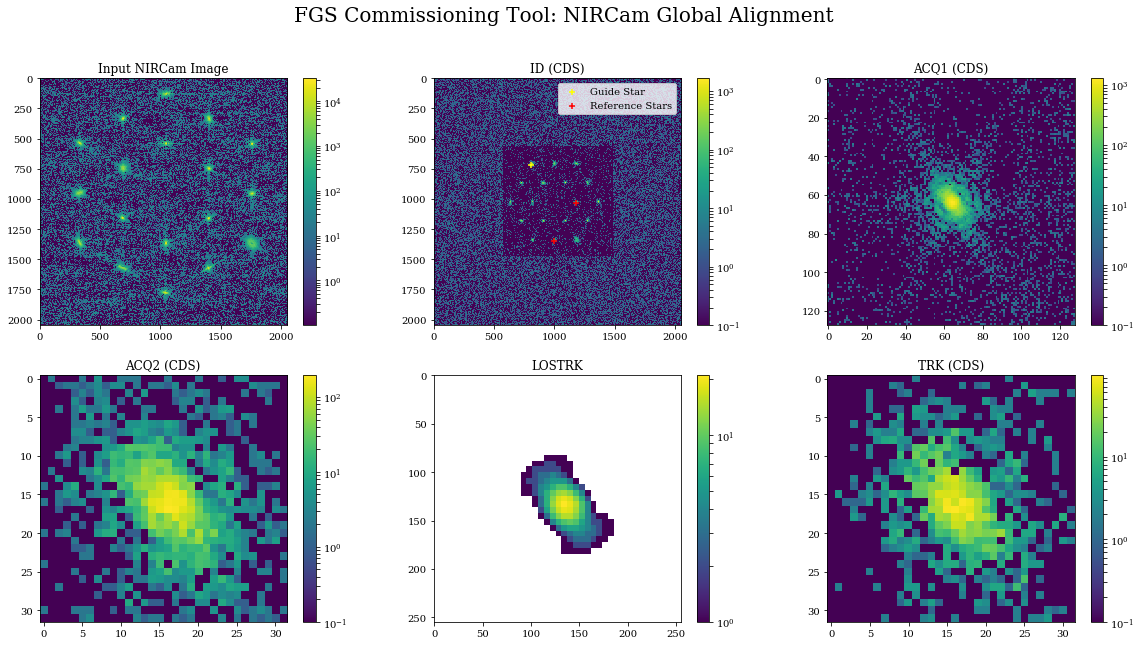

In [9]:
# View the final FGS images
%matplotlib inline
current_dir = os.getcwd()
package_dir = os.path.split(current_dir)[0]
out_dir = os.path.join(package_dir, 'out', root_nc_ga)

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('FGS Commissioning Tool: NIRCam Global Alignment', fontsize=20)

in_data = fits.open(input_image_nc_ga)[1].data
in_data[in_data <= 0] = 0.1
implot = ax1.imshow(in_data, norm=LogNorm())
plt.colorbar(implot, ax=ax1)
ax1.set_title('Input NIRCam Image')

id_data = fits.open(glob(out_dir + '/stsci/*IDcds.fits')[0])[0].data[0]
id_data[id_data <= 0] = 0.1
implot = ax2.imshow(id_data, norm=LogNorm())
plt.colorbar(implot, ax=ax2)
regfile = glob(out_dir + '/*regfile.txt')[0]
coords = asc.read(regfile)
ax2.scatter(coords['x'][0], coords['y'][0], marker = '+', c= 'yellow', label='Guide Star')
ax2.scatter(coords['x'][1:], coords['y'][1:], marker = '+', c= 'r', label='Reference Stars')
ax2.legend()
ax2.set_title('ID (CDS)')

acq1_data = fits.open(glob(out_dir + '/stsci/*ACQ1cds.fits')[0])[0].data[0]
acq1_data[acq1_data <= 0] = 0.1
implot = ax3.imshow(acq1_data, norm=LogNorm())
plt.colorbar(implot, ax=ax3)
ax3.set_title('ACQ1 (CDS)')

acq2_data = fits.open(glob(out_dir + '/stsci/*ACQ2cds.fits')[0])[0].data[0]
acq2_data[acq2_data <= 0] = 0.1
implot = ax4.imshow(acq2_data, norm=LogNorm())
plt.colorbar(implot, ax=ax4)
ax4.set_title('ACQ2 (CDS)')

lostrk_data = fits.open(glob(out_dir + '/dhas/*LOSTRK.fits')[0])[0].data
lostrk_data[lostrk_data <= 0] = 0.1
implot = ax5.imshow(lostrk_data, norm=LogNorm())
plt.colorbar(implot, ax=ax5)
ax5.set_title('LOSTRK')

trk_data = fits.open(glob(out_dir + '/dhas/*_TRK.fits')[0])[0].data.astype(float)
trk_data_cds = trk_data[1] - trk_data[0]
trk_data_cds[trk_data_cds <= 0] = 0.1
implot = ax6.imshow(trk_data_cds, norm=LogNorm())
plt.colorbar(implot, ax=ax6)
ax6.set_title('TRK (CDS)')

plt.show()

***
<a id='nircamtofgs'></a>
# Converting NIRCam images to FGS images: `convert_image`

The function used to convert NIRCam (detector frame) image into FGS (raw frame) images, `convert_image.convert_image_to_raw_fgs.convert_im`, takes the following arguments:


> Required:
* **`input_image`** - filepath for the input (NIRCam or FGS) image
* **`guider`** - number for guider 1 or guider 2

> Optional:
* **`nircam`** -  denotes if the input_image is an FGS or NIRCam image. If True, the image will be converted to FGS format using the nircam_to_fgs.convert_im function. Unless `output_path` is specified, the FGS-formatted image will be saved to `../out/{input_image}/FGS_imgs/{input_image}_binned_pad_norm.fits`
* **`nircam_det`** - used to specify the detector of a provided NIRCam image. If left blank, the detector will be extracted from the header of the NIRCam FITS file.
* **`fgs_counts`** and **`jmag`** - used to normalize the input NIRCam image, either to a desired J magnitude or to a desired number of FGS counts. The `jmag` parameter can also be used to normalize an FGS image.
* **`output_path`** - where output FGS image(s) will be saved to. If the output path is not provided, the image(s) will be saved to `../out/{input_image}`.

**Note:** Like the full tool, running convert_im will create an `out` directory (whether you want it to or not) in the directory where you are running this script. Inside the `./out/` directory will be directories for every image that you run the script for, with the output FGS `bin_norm_img.fits` inside.

In [10]:
from jwst_fgs_commissioning_tools.convert_image import convert_image_to_raw_fgs

In [11]:
input_im = '/user/lchambers/FGS/tool_tutorial/NIRCam_files/jw00000_044_001_01100_00000_NRCA3_img.fits'
guider = 2
root = 'tool_tutorial_im_convertor'

nircam = True # default
nircam_det = None # default

fgs_counts = None # default
jmag = None # default

output_path = None # default

In [12]:
fgs_im = convert_image_to_raw_fgs.convert_im(input_im, guider, root)

2018-02-27 10:56:43,795 WARNING  Image Conversion: No counts or J magnitude given, setting to default
2018-02-27 10:56:43,797 INFO     Image Conversion: J magnitude = 11.0, FGS counts = 12656176.4
2018-02-27 10:56:43,798 INFO     Image Conversion: Beginning image conversion to guider 2 FGS image
2018-02-27 10:56:43,812 INFO     Image Conversion: This is a NIRCam image
2018-02-27 10:56:47,225 INFO     Image Conversion: NIRCAM Detector = A3
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_im_convertor/FGS_imgs/tool_tutorial_im_convertor_G2.fits
2018-02-27 10:56:47,788 INFO     Image Conversion complete for tool_tutorial_im_convertor, guider = 2


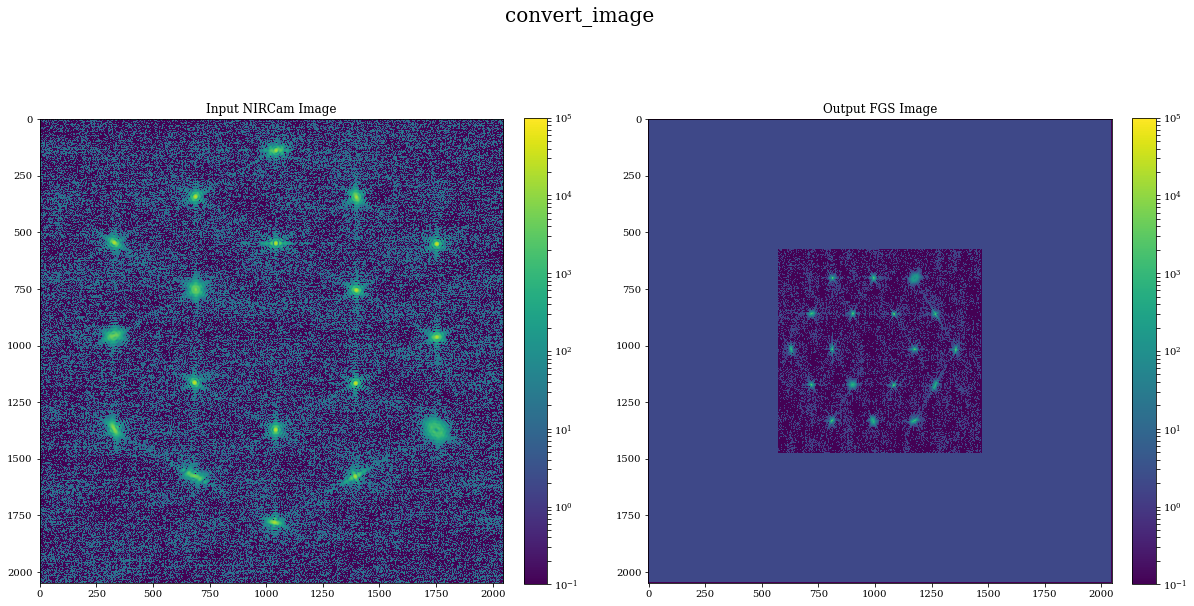

In [14]:
# View the input NIRCam images and output FGS images
%matplotlib inline
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('convert_image', fontsize=20)

in_data = fits.open(input_im)[1].data
in_data[in_data <= 0] = 0.1
implot = ax1.imshow(in_data, norm=LogNorm(), clim=(1e-1, 1e5))
plt.colorbar(implot, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title('Input NIRCam Image')

out_file = os.path.join(package_dir, 'out', 
                        '{}/FGS_imgs/{}_G{}.fits'.format(root, root, guider))

out_data = fits.open(out_file)[0].data
out_data = out_data.astype(float)
out_data[out_data <= 0] = 0.1
implot = ax2.imshow(out_data, norm=LogNorm(), clim=(1e-1, 1e5))
plt.colorbar(implot, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title('Output FGS Image')

plt.show()

***
<a id='starselector'></a>
# Selecting guide and reference stars: `star_selector`

The function used to select guide and reference stars, `star_selector.select_psfs.create_reg_file`, takes the following arguments:

> Required:
* **`data`** - array of the data in which to find stars
* **`guider`** - number for guider 1 or guider 2
* **`root`** - will be used to create/find the output directory, `../out/{root}` and write out the files

> Optional:
* **`global_alignment`** - set to `True` if the provided image data is from global alignment, or the PSF-finding algorithm will go haywire.
* **`in_file`** - a table of X/Y pixel coordinates and count rates that lists the desired guide star and reference stars; allows users to bypass the star selector GUI and directly write out the `regfile` and `ALLpsfs` files; provided in the form of a filepath to a `regfile.txt` or `.incat` file

When the `create_reg_file()` function is called, the following files will be created in the `../out/{root}` directory:
* `reg_file.txt` - a list of the pixel coordinates and 3x3 countrate sums of the selected guide and reference stars
* `ALLpsfs.txt` - a list of the pixel coordinates, 3x3 countrate sums, and segment identifier (letter label) of all PSFs found in the image
* `centers.png` - a saved image of the input FGS file, annotated with the locations of all PSFs found in the image

In [15]:
from jwst_fgs_commissioning_tools.star_selector import select_psfs

In [17]:
# Take care of matplotlib backend business
%matplotlib qt5
plt.close('all')

# Run the star selector
select_psfs.create_reg_file(out_data, 'tool_tutorial_star_selector', 2, global_alignment=True)

2018-02-27 10:57:42,092 INFO     Star Selection: 18 PSFs detected in Gaussian-smoothed data             (threshold = 10.229645569485267; sigma = 26)
2018-02-27 10:57:54,605 INFO     Star Selection: 1 guide star and 2 reference stars selected
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_star_selector/tool_tutorial_star_selector_G2_ALLpsfs.txt
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_star_selector/tool_tutorial_star_selector_G2_regfile.txt


Let's look at what these output files, the `ALLpsfs.txt` and `regfile.txt`, look like.

In [18]:
ALL_psfs = os.path.join(package_dir, 'out', 
                        'tool_tutorial_star_selector/tool_tutorial_star_selector_G2_ALLpsfs.txt')
reg_file = os.path.join(package_dir, 'out',
                        'tool_tutorial_star_selector/tool_tutorial_star_selector_G2_regfile.txt')

print(asc.read(ALL_psfs))
print(asc.read(reg_file))

label   y      x    countrate
----- ------ ------ ---------
    D  701.0  814.0   34741.0
    I  701.0  996.0   21889.0
    M  702.0 1178.0     233.0
    B  858.0  722.0   17235.0
    G  858.0  904.0   28360.0
    K  860.0 1086.0   32849.0
    P  860.0 1268.0   17270.0
    A 1015.0  631.0   16439.0
    E 1015.0  813.0   24553.0
    N 1016.0 1177.0   27906.0
    R 1018.0 1358.0   20576.0
    C 1172.0  721.0   27990.0
    H 1172.0  903.0    8337.0
    L 1174.0 1085.0   31232.0
    Q 1175.0 1267.0    6288.0
    F 1331.0  811.0   24160.0
    O 1331.0 1175.0   10334.0
    J 1332.0  993.0    6280.0
  y      x    countrate
------ ------ ---------
 701.0  814.0   34741.0
 860.0 1268.0   17270.0
1332.0  993.0    6280.0


<a id='in_file'></a>
### Providing an `in_file`
You can also run `select_psfs.create_reg_file` without the star selector GUI, if you provide a regfile to the tool that specifies the X and Y positions and count rates of the desired stars. The first star in the regfile will be used as the guide star, and all subsequent stars will be reference stars. (Note that a maximum of 10 reference stars can be commanded to the flight software.)

In [20]:
select_psfs.create_reg_file(out_data, 'tool_tutorial_star_selector', 
                            2, global_alignment=True, in_file=reg_file)

2018-02-27 10:58:27,984 INFO     Star Selection: Selecting stars from input file /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_star_selector/tool_tutorial_star_selector_G2_regfile.txt
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_star_selector/tool_tutorial_star_selector_G2_regfile.txt


***
<a id='fswfilewriter'></a>
# Writing flight software files: `fsw_file_writer`

The class object used to write out necessary flight software files, `fsw_file_writer.buildfgssteps.BuildFGSSteps`, takes the following arguments:

> Required:
* **`input_image`** - filepath or array of the data
* **`guider`** - number for guider 1 or guider 2
* **`root`** - will be used to create/find the output directory, `../out/{root}` and write out the files
* **`step`** - the FGS step for which you would like to write files (ID, ACQ1, ACQ2, TRK, or LOSTRK)

> Optional:
* **`reg_file`** - if provided, determines which segments the tool outputs as the guide star and reference stars. If not provided, the code will search for a `regfile.txt` in the `../out/{root}` directory
* **`configfile`** - the file that defines the parameters for each step, e.g. CDS time, number of ramps, bias application. (You almost certainly don't want to mess with this.)

When the `BuildFGSSteps` object is built for a step, the following files will be created for in the `../out/{root}` directory:

* ID:
 * `sky.fits` (the input file after being time-normalized (converted from counts/s to counts)
 * `bias.fits` (bias file used to create noisy FGS image)
 * `cds.fits` (correlated double sample)
 * `ff.fits` (full frame; image before CDS)
 * `strips.fits` (strips to run in DHAS)
 * `strips.dat` (strips to run in FGSES)
 * `.gssscat`
 * `.stc`
 * `.prc` (to run in DHAS or FGSES)
* ACQ1 or ACQ2:
 * `sky.fits` (the input file after being time-normalized (converted from counts/s to counts)
 * `bias.fits` (bias file used to create noisy FGS image)
 * `cds.fits` (correlated double sample)
 * `.fits` (to run in DHAS)
 * `.dat` (to run in FGSES)
 * `.cat`
 * `.stc`
 * `.prc` (to run in DHAS or FGSES)
* LOSTRK:
 * `.fits`
 * `.dat` (to run in FGSES)
* TRK:
 * `.fits` (to run in DHAS)

In [21]:
from jwst_fgs_commissioning_tools.fsw_file_writer import buildfgssteps

In [22]:
buildfgssteps.BuildFGSSteps(out_data, 2, 'tool_tutorial_fsw_file_writer', 'ID', reg_file=reg_file)

2018-02-27 10:58:35,733 INFO     FSW File Writing: Max of input image: 4386
2018-02-27 10:58:35,734 INFO     FSW File Writing: Using /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_star_selector/tool_tutorial_star_selector_G2_regfile.txt as the reg file
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_fsw_file_writer/stsci/tool_tutorial_fsw_file_writer_G2_IDsky.fits
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_fsw_file_writer/stsci/tool_tutorial_fsw_file_writer_G2_ID.stc
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_fsw_file_writer/stsci/tool_tutorial_fsw_file_writer_G2_IDbias.fits
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_fsw_file_writer/stsci/tool_tutorial_fsw_file_writer_G2_IDcds.fits
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-com

<a id='rewrite'></a>
# Rewriting `ID.prc` and `regfile.txt` files for iterative DHAS testing: `rewrite_prc`

If you are testing, say, a range of geometries for guide and reference stars on a single global alignment ID image in the DHAS, it would be obnoxious and cumbersome to re-run the entire tool every time you just want to command a different set of guide/reference stars. The only things that needs to be re-written in this case are the `ID.prc` file and the `regfile.txt` that lists the commanded stars' positions and countrates; the output `.fits` image that is fed into DHAS will be the same.

There is an ancillary script in the `fsw_file_writer` package, `rewrite_prc` that can be used in cases like this, which just re-write the `ID.prc` and `regfile.txt` files according to user input.

The user input is provided as a series of letters, corresponding to segments of JWST as shown below. The first letter corresponds to the guide star segment.
<table><tr><td><img src="JWSTgrid.png" style="width: 400px;"></td><td><img src="JWSTgrid_side.png" style="width: 400px;"></td></tr></table>

In [23]:
from jwst_fgs_commissioning_tools.fsw_file_writer import rewrite_prc

In [24]:
guider = 1
root = 'tool_tutorial_ncga' # MUST match the root of the file you are trying to alter
out_dir = os.path.join(package_dir, 'out', root) # Where to find the prc

# The thresh_factor is the percentage of the PSF countrate that is used as DHAS threshold.
# (e.g. if thresh_factor is 0.9 and the countrate is 100, the threshold provided to DHAS will be 90)
thresh_factor = 0.9 # default

order = 'OPHIA'

rewrite_prc.rewrite_prc(order, guider, root, out_dir)

Reading from (and writing to) /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_ncga
Threshold: 0.9
Number of reference stars: 4
Successfully wrote: tool_tutorial_ncga_G1_ID.prc
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_ncga/tool_tutorial_ncga_G1_regfile.txt


***
<a id='segmentguiding'></a>
# Segment guiding override: `segment_guiding`

The function used to call the segment guiding tool, `segment_guiding.segment_guiding.run_tool`, takes the following arguments:
> Required:
* **`segment_infile`** - filepath to the list of all segment positions as V2/V3 offsets or X/Y pixel values.

> Optional:
* **`root`** - if defined, will be used to name the files. If not provided, the root name will be derived from the `segment_infile` filename.
* **`GUI`** - if True, will run the tool using a Tkinter GUI
* **`selected_segs`** - a regfile.txt that, if provided, determines which segments the tool outputs as the guide star and reference stars
* **`vss_infile`** - a VSS-formated .txt file that, if provided, will be parsed to read the guide star RA, Dec, PA, and the FGS number
* **`GS_params_dict`** - if running the tool outside of the GUI, must pass a dictionary of guide star parameters of the following form:
>```
GS_params_dict = {'V2Boff': 0.1,  # V2 boresight offset
                   'V3Boff': 0.2,  # V3 boresight offset
                   'fgsNum': 1,  # guider number
                   'RA': 30.,  # RA of guide star
                   'Dec': 50.,  # Dec of guide star
                   'PA': 2.,  # position angle of guide star
                   'segNum': 0}  # selected segment to guide on
```

Output files from the tool will be stored in `../segment_guiding_files`. The output files are the following:
> 
* **`gs-override...txt`** - file containing the effective RA, Decs, and countrates for each of the selected segments. Formatted for immediate delivery to VSS.
* **`V2V3segments.png`** - plot of all segments in the V2/V3 frame
* **`RADecsegments.png`** - plot of all segment RA/Decs projected on to the sky

In [25]:
from jwst_fgs_commissioning_tools.segment_guiding import segment_guiding

/Users/lchambers/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [28]:
GS_params_dict = {'V2Boff': 0.1,  # V2 boresight offset
                  'V3Boff': 0.2,  # V3 boresight offset
                  'fgsNum': 1,  # guider number
                  'RA': 30.,  # RA of guide star
                  'Dec': 50.,  # Dec of guide star
                  'PA': 2.,  # position angle of guide star
                  'segNum': 0}  # selected segment to guide on

segment_infile = 'SGTintegrationexample_G1_ALLpsfs.txt'
selected_segs = 'SGTintegrationexample_G1_regfile.txt'
vss_infile = '710_GS_Report.txt'

Reading all GS parameters from user-provided dictionary.
Segment coordinates read from SGTintegrationexample_G1_ALLpsfs.txt
18 Segments in input file.
Selected segment coordinates read from SGTintegrationexample_G1_regfile.txt

Summary
Aperture FGS 1
V2Ref   207.1900 V3Ref  -697.5000 arc-sec IdlAngle    -1.2508 degrees
Used segment 0
Boresight offset 0.1 0.2 arc-sec
Guide star at RA 30.0  Dec 50.0 degrees
Position angle 2.0 degrees

Segment     dV2    dV3    xIdl   yIdl     RA         Dec         xDet     yDet
    1    -30.77   3.22  -30.69   3.89   29.988998  50.000209    575.00   981.00
    2    -24.70  14.41  -24.38  14.95   29.991788  50.003257    667.00   820.00
    3    -24.15  -8.01  -24.32  -7.48   29.991686  49.997028    669.00  1141.00
    4    -18.64  25.56  -18.07  25.96   29.994575  50.006294    759.00   659.00
    5    -18.09   3.23  -18.01   3.62   29.994476  50.000089    761.00   980.00
    6    -17.57 -19.23  -17.99 -18.84   29.994359  49.993849    762.00  1300.00
    

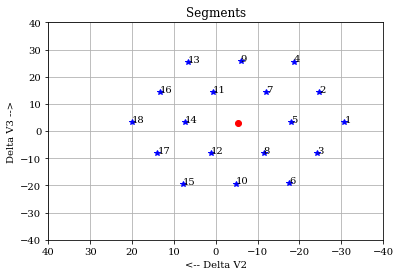

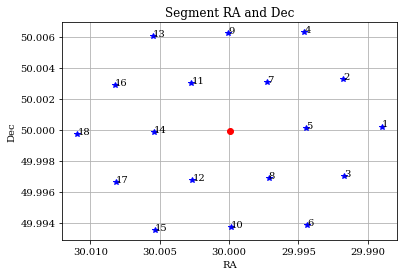

In [30]:
# Get GS override file with segment selection
%matplotlib inline
segment_guiding.run_tool(segment_infile, 
                         selected_segs=selected_segs,
                         GS_params_dict=GS_params_dict)

Reading RA, Dec, and PA from vss file; reading boresight offset and segment number from user-provided dictionary.
Segment coordinates read from SGTintegrationexample_G1_ALLpsfs.txt
18 Segments in input file.
Selected segment coordinates read from SGTintegrationexample_G1_regfile.txt

Summary
Aperture FGS 1
V2Ref   207.1900 V3Ref  -697.5000 arc-sec IdlAngle    -1.2508 degrees
Used segment 0
Boresight offset 0.1 0.2 arc-sec
Guide star at RA 273.18584587  Dec 65.5365082 degrees
Position angle 13.2575945 degrees

Segment     dV2    dV3    xIdl   yIdl     RA         Dec         xDet     yDet
    1    -30.77   3.22  -30.69   3.89  -86.830806  65.538093    575.00   981.00
    2    -24.70  14.41  -24.38  14.95  -86.825122  65.540733    667.00   820.00
    3    -24.15  -8.01  -24.32  -7.48  -86.828212  65.534636    669.00  1141.00
    4    -18.64  25.56  -18.07  25.96  -86.819446  65.543362    759.00   659.00
    5    -18.09   3.23  -18.01   3.62  -86.822522  65.537289    761.00   980.00
    6 

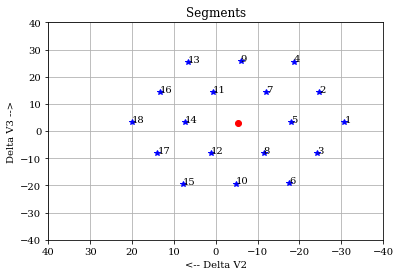

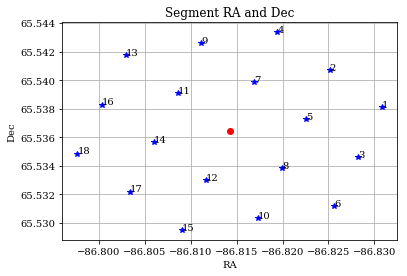

In [31]:
# Get GS override file with segment selection and parameters from VSS
%matplotlib inline
segment_guiding.run_tool(segment_infile, 
                         selected_segs=selected_segs,
                         vss_infile=vss_infile,
                         GS_params_dict=GS_params_dict)

### Using the segment guiding tool with a GUI

The segment guiding tool can be run as a GUI. However, the GUI can only be run:

1. if matplotlib has been loaded with the TkAgg backend, and
2. in non-interactive python.

If matplotlib has already been loaded with a different backend, then you need to completely restart python and begin again with the TkAgg backend. Note that the backend cannot be changed after pyplot or any other matplotlib modules are imported; it must be defined beforehand.

While the GUI sometimes runs successfully in the `IPython` shell, the Tkinter GUI cannot be run from a jupyter notebook. The best method to use the segment guiding tool with the GUI is in a python terminal, like so:
```
>>> import matplotlib
>>> matplotlib.use('TkAgg')
>>> from jwst_fgs_commissioning_tools.segment_guiding import segment_guiding
>>> segment_infile = 'full/path/to/ALLpsfs.txt'
>>> segment_guiding.run_tool(segment_infile, GUI=True)
```

***
<a id='ipython'></a>
# Running the tools with `IPython`

As mentioned in notes above, the FGS commissioning tools can also be run from an `IPython` shell. Here is an example of what running the tool from end-to-end might look like:

```
In[1]: from jwst_fgs_commissioning_tools import run_fgs_commissioning_tool

In[2]: input_image = ‘full/path/to/image.fits’

In[3]: guider = 1

In[4]: run_fgs_commissioning_tool.run_all(input_image, guider)

```

or, just using the segment guiding tool:

```
In[1]: from jwst_fgs_commissioning_tools.segment_guiding import segment_guiding

In[2]: segment_infile = ‘full/path/to/ALLpsfs.txt’

In[3]: vss_infile = 'full/path/to/Report.txt'

In[4]: segment_guiding.run_tool(segment_infile, vss_infile=vss_infile)

```